In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
image = Image.open('C:/Users/Admin/Desktop/A.N lab/extract-information-from-identity-card/samples/img_10.png')
image = np.asarray(image)

In [ ]:
image.shape

# Corners detection

### NMS (Non Maximum Suppression)

In [10]:
def non_max_suppression_fast(boxes, labels, overlapThresh):
    """ filters object detector predictions / removes duplicates

    Args:
        boxes: 
        labels:
        overlap threshold: 
    Returns:
        the bounding boxes that were picked using the integer data type
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 3]
    y2 = boxes[:, 2]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    final_labels = [labels[idx] for idx in pick]
    final_boxes = boxes[pick].astype("int")
    return final_boxes, final_labels

### Corner detect

In [7]:
import cv2
import tensorflow as tf
# from src.detector.utils.image_utils import non_max_suppression_fast
# from src.detector.utils import load_label_map

category_index = {
    1: {'id': 1, 'name': 'top_left'},
    2: {'id': 2, 'name': 'top_right'},
    3: {'id': 3, 'name': 'bottom_right'},
    4: {'id': 4, 'name': 'bottom_left'},
}
class Detector(object):
    def __init__(self, path_to_model, path_to_labels, nms_threshold=0.15, score_threshold=0.3):
        self.path_to_model = path_to_model
        self.path_to_labels = path_to_labels
        self.category_index = category_index
        self.nms_threshold = nms_threshold
        self.score_threshold = score_threshold

        # load model
        self.interpreter = self.load_model()

        # Get input and output tensors.
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        self.detection_scores = None
        self.detection_boxes = None
        self.detection_classes = None

    def load_model(self):
        # Load the TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=self.path_to_model)
        interpreter.allocate_tensors()

        return interpreter

    def predict(self, img):
        """
        return: self.detection_boxes, np.array(self.detection_classes).astype("int"), self.category_index
        """
        original = img
        height = self.input_details[0]['shape'][1]
        width = self.input_details[0]['shape'][2]
        img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
        img = np.expand_dims(img, axis=0)

        # Normalize input data
        input_mean = 127.5
        input_std = 127.5
        input_data = (np.float32(img) - input_mean) / input_std
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

        self.interpreter.invoke()

        # Retrieve detection results
        self.detection_boxes = self.interpreter.get_tensor(self.output_details[0]['index'])[
            0]  # Bounding box coordinates of detected objects
        self.detection_classes = self.interpreter.get_tensor(self.output_details[1]['index'])[
            0]  # Class index of detected objects
        self.detection_scores = self.interpreter.get_tensor(self.output_details[2]['index'])[
            0]  # Confidence of detected objects

        mask = np.array(self.detection_scores) > self.score_threshold
        self.detection_boxes = np.array(self.detection_boxes)[mask]
        self.detection_classes = np.array(self.detection_classes)[mask]

        self.detection_classes += 1

        # Convert coordinate to original coordinate
        h, w, _ = original.shape
        self.detection_boxes[:, 0] = self.detection_boxes[:, 0] * h
        self.detection_boxes[:, 1] = self.detection_boxes[:, 1] * w
        self.detection_boxes[:, 2] = self.detection_boxes[:, 2] * h
        self.detection_boxes[:, 3] = self.detection_boxes[:, 3] * w

        # Apply non-max suppression
        self.detection_boxes, self.detection_classes = non_max_suppression_fast(boxes=self.detection_boxes,
                                                                                labels=self.detection_classes,
                                                                                overlapThresh=self.nms_threshold)
        
        # return
        return self.detection_boxes, np.array(self.detection_classes).astype("int"), self.category_index

    def draw(self, image):
        self.detection_boxes, self.detection_classes, self.category_index = self.predict(image)
        height, width, _ = image.shape

        for i in range(len(self.detection_classes)):
            label = str(self.category_index[self.detection_classes[i]]['name'])
            real_ymin = int(max(1, self.detection_boxes[i][0]))
            real_xmin = int(max(1, self.detection_boxes[i][1]))
            real_ymax = int(min(height, self.detection_boxes[i][2]))
            real_xmax = int(min(width, self.detection_boxes[i][3]))

            cv2.rectangle(image, (real_xmin, real_ymin), (real_xmax, real_ymax), (255, 0, 0), 2)
            cv2.putText(image, label, (real_xmin, real_ymin), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
                        fontScale=0.5)

        return image
    


In [8]:
# Sanity check
corner_detection = {
    'path_to_model': './src/detector/config_corner_detection/model.tflite',
    'path_to_labels': './src/detector/config_corner_detection/label_map.pbtxt',
    'nms_ths': 0.2,
    'score_ths': 0.3
}

corner_detection_model = Detector(path_to_model=corner_detection['path_to_model'],
                                            path_to_labels=corner_detection['path_to_labels'],
                                            nms_threshold=corner_detection['nms_ths'], 
                                            score_threshold=corner_detection['score_ths'])

### Corner detection test

In [27]:
import os
imgs_path = 'C:/Users/Admin/Desktop/A.N lab/extract-information-from-identity-card/samples'
paths = os.listdir(imgs_path)

# Create an empty list to store image arrays
img_arr = []

for path in paths:
    img_dir = f'{imgs_path}/{path}'
    img = Image.open(img_dir)
    img = np.asarray(img)

    # Check if the image has 4 channels (RGBA)
    if len(img.shape) > 2 and img.shape[2] == 4:
        # Convert RGBA to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # 4 corners detection
    cropped = corner_detection_model.draw(img)
    img_arr.append(cropped)

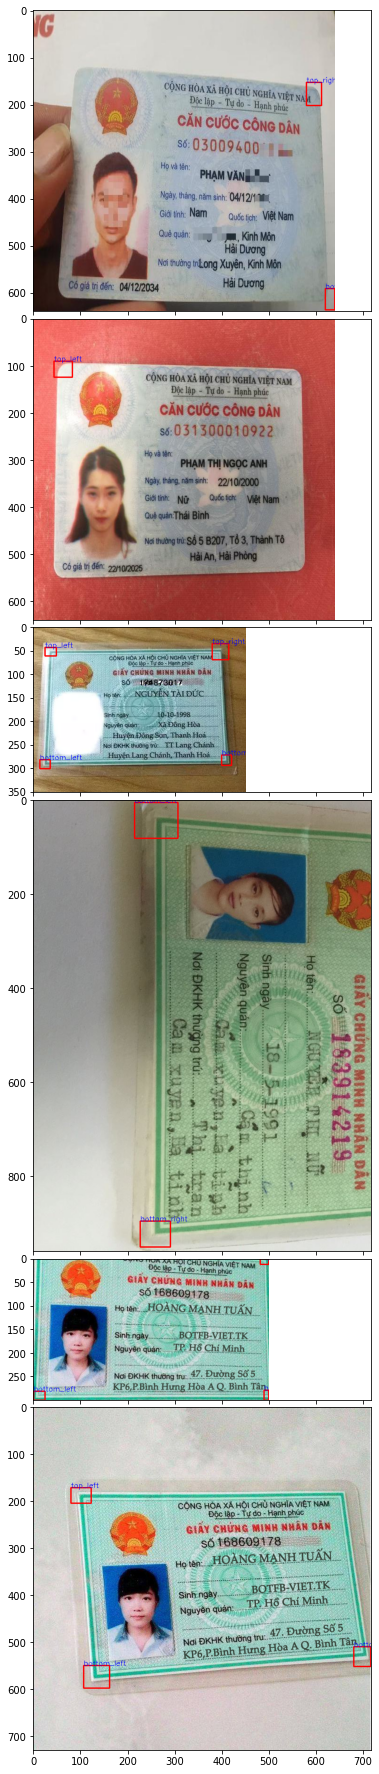

In [35]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Define the grid layout
rows, cols = int(len(img_arr)), 1

fig = plt.figure(figsize=(4 * rows, 32 * cols))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.1)

# Display images in the grid
for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()

In [ ]:
test5_image = Image.open('C:/Users/Admin/Desktop/A.N lab/extract-information-from-identity-card/samples/test_5.jpg')
test5_img = np.asarray(test5_image)
test5_img.shape

In [15]:
img10 = Image.open('C:/Users/Admin/Desktop/A.N lab/extract-information-from-identity-card/samples/img_10.png')
img10 = np.asarray(img10)
img10.shape

(960, 1280, 3)

In [13]:
fake = Image.open('C:/Users/Admin/Desktop/A.N lab/extract-information-from-identity-card/samples/cccd.jpg')
fake = np.asarray(fake)
fake.shape

(640, 640, 3)

In [16]:
img2 = Image.open('C:/Users/Admin/Desktop/A.N lab/extract-information-from-identity-card/samples/img2.png')
img2 = np.asarray(img2)

# Check if the image has 4 channels (RGBA)
if len(img2.shape) > 2 and img2.shape[2] == 4:
    # Convert RGBA to RGB
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2BGR)
img2.shape

(352, 451, 3)

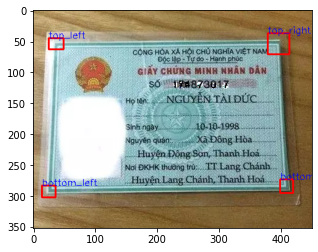

In [17]:
# 4 corners detection
cropped = corner_detection_model.draw(img2)
plt.imshow(cropped)


## Alignment
- transform (rotate) and crop from 4 detected corners

In [ ]:
from src.detector.detector import Detector
from src.detector.utils.image_utils import align_image

corner_detection = {
    'path_to_model': './src/detector/config_corner_detection/model.tflite',
    'path_to_labels': './src/detector/config_corner_detection/label_map.pbtxt',
    'nms_ths': 0.2,
    'score_ths': 0.3
}

corner_detection_model = Detector(path_to_model=corner_detection['path_to_model'],
                                            path_to_labels=corner_detection['path_to_labels'],
                                            nms_threshold=corner_detection['nms_ths'], 
                                            score_threshold=corner_detection['score_ths'])


detection_boxes, detection_classes, category_index = corner_detection_model.predict(image)

coordinate_dict = dict()
height, width, _ = image.shape

for i in range(len(detection_classes)):
    label = str(category_index[detection_classes[i]]['name'])
    real_ymin = int(max(1, detection_boxes[i][0]))
    real_xmin = int(max(1, detection_boxes[i][1]))
    real_ymax = int(min(height, detection_boxes[i][2]))
    real_xmax = int(min(width, detection_boxes[i][3]))
    coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

# align image
cropped_img = align_image(image, coordinate_dict)

In [ ]:
import cv2


def get_center_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax = coordinate_dict[key]
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        di[key] = (x_center, y_center)

    return di


def find_miss_corner(coordinate_dict):
    position_name = ['top_left', 'top_right', 'bottom_left', 'bottom_right']
    position_index = np.array([0, 0, 0, 0])

    for name in coordinate_dict.keys():
        if name in position_name:
            position_index[position_name.index(name)] = 1

    index = np.argmin(position_index)

    return index


def calculate_missed_coord_corner(coordinate_dict):
    thresh = 0

    index = find_miss_corner(coordinate_dict)

    # calculate missed corner coordinate
    # case 1: missed corner is "top_left"
    if index == 0:
        midpoint = np.add(coordinate_dict['top_right'], coordinate_dict['bottom_left']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_right'][0] - thresh
        coordinate_dict['top_left'] = (x, y)
    elif index == 1:  # "top_right"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_left'][0] - thresh
        coordinate_dict['top_right'] = (x, y)
    elif index == 2:  # "bottom_left"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_right'][0] - thresh
        coordinate_dict['bottom_left'] = (x, y)
    elif index == 3:  # "bottom_right"
        midpoint = np.add(coordinate_dict['bottom_left'], coordinate_dict['top_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_left'][0] - thresh
        coordinate_dict['bottom_right'] = (x, y)

    return coordinate_dict


def perspective_transform(image, source_points):
    dest_points = np.float32([[0, 0], [500, 0], [500, 300], [0, 300]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (500, 300))

    return dst


def align_image(image, coordinate_dict):
    if len(coordinate_dict) < 3:
        raise ValueError('Please try again')

    # convert (xmin, ymin, xmax, ymax) to (x_center, y_center)
    coordinate_dict = get_center_point(coordinate_dict)

    if len(coordinate_dict) == 3:
        coordinate_dict = calculate_missed_coord_corner(coordinate_dict)

    top_left_point = coordinate_dict['top_left']
    top_right_point = coordinate_dict['top_right']
    bottom_right_point = coordinate_dict['bottom_right']
    bottom_left_point = coordinate_dict['bottom_left']

    source_points = np.float32([top_left_point, top_right_point, bottom_right_point, bottom_left_point])

    # transform image and crop
    crop = perspective_transform(image, source_points)

    return crop

# align image
cropped_img = align_image(image, coordinate_dict)

In [ ]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(cropped_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

# Completed model

In [ ]:
import matplotlib.pyplot as plt
from src.merged_model import CompletedModel

model = CompletedModel()
cropped_img = model.detect_corner(image)

plt.imshow(cropped_img)